## Setup

In [1]:
# !git clone https://github.com/sanskar-hasija/vit_modelling

# %cd vit_modelling

# from google.colab import drive
# drive.mount('/content/drive')


# !cp '/content/drive/MyDrive/FR/VIT_Modelling/images.zip' .
# !unzip images.zip

## Imports

In [2]:
import os
import sys

sys.path.append('..')
import datetime
import time
import math
import json
from pathlib import Path
from collections import defaultdict, deque

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, DistributedSampler

from torchvision import datasets, transforms
from torchvision import models as torchvision_models

# HuggingFace imports
from transformers import ViTConfig, ViTModel
from huggingface_hub import HfApi, upload_folder, create_repo

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
import utils
from vision_transformer import DINOHead

## Config

In [ ]:
class Config:
    # Architecture
    PATCH_SIZE = 16

    # Training parameters
    EPOCHS = 500
    BATCH_SIZE_PER_GPU = 32
    OUT_DIM = 384
    LR = 0.005
    WARMUP_EPOCHS = 1
    FREEZE_LAST_LAYER = 10

    # Teacher temperature parameters
    TEACHER_TEMP = 0.07
    WARMUP_TEACHER_TEMP = 0.04
    WARMUP_TEACHER_TEMP_EPOCHS = 1

    # Momentum teacher
    MOMENTUM_TEACHER = 0.999

    # Multi-crop parameters
    LOCAL_CROPS_NUMBER = 4
    GLOBAL_CROPS_SCALE = (0.4, 1.)
    LOCAL_CROPS_SCALE = (0.05, 0.4)

    # Data parameters
    DATA_PATH = './images'
    OUTPUT_DIR = './dino_hf_checkpoints'
    NUM_WORKERS = 0

    # Other training parameters (defaults)
    NORM_LAST_LAYER = True
    USE_BN_IN_HEAD = False
    USE_FP16 = True
    WEIGHT_DECAY = 0.04
    WEIGHT_DECAY_END = 0.4
    CLIP_GRAD = 3.0
    MIN_LR = 1e-6
    OPTIMIZER = 'adamw'
    DROP_PATH_RATE = 0.1

    # Checkpoint parameters
    SAVECKP_FREQ = 20
    SEED = 0

    # Distributed training
    DIST_URL = "env://"
    LOCAL_RANK = 0

    # HuggingFace Hub
    HF_REPO_NAME = "odinson/dino-vit-small-custom"  # Change this!
    HF_TOKEN = 'REMOVED'  # Set your HF token here

In [4]:
config = Config()

# Create output directory
Path(config.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Utils

In [5]:
class MetricsTracker:
    def __init__(self):
        self.losses = []
        self.lrs = []
        self.wds = []
        self.epochs = []

    def update(self, loss, lr, wd, epoch):
        self.losses.append(loss)
        self.lrs.append(lr)
        self.wds.append(wd)
        self.epochs.append(epoch)

    def plot(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Loss plot
        axes[0].plot(self.epochs, self.losses)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss')
        axes[0].grid(True)

        # Learning rate plot
        axes[1].plot(self.epochs, self.lrs)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Learning Rate')
        axes[1].set_title('Learning Rate Schedule')
        axes[1].grid(True)

        # Weight decay plot
        axes[2].plot(self.epochs, self.wds)
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Weight Decay')
        axes[2].set_title('Weight Decay Schedule')
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()

    def save(self, path):
        data = {
            'losses': self.losses,
            'lrs': self.lrs,
            'wds': self.wds,
            'epochs': self.epochs
        }
        with open(path, 'w') as f:
            json.dump(data, f)

class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(1.0),
            normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(0.1),
            utils.Solarization(0.2),
            normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.resize = transforms.Resize(224)
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(p=0.5),
            normalize,
            self.resize,
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        if dist.is_initialized():
            dist.all_reduce(batch_center)
            batch_center = batch_center / (len(teacher_output) * dist.get_world_size())
        else:
            batch_center = batch_center / len(teacher_output)

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

def collate_fn(batch):
    """
    Custom collate function to handle multi-crop augmentation.
    Input batch: list of (crops_list, label) tuples
    Output: (list of stacked tensors for each crop position, stacked labels)
    """
    # batch is a list of (crops, label) tuples
    # where crops is a list of tensors (different augmented views)

    # Separate crops and labels
    crops_list = [item[0] for item in batch]  # Each item is a list of crops
    labels = torch.tensor([item[1] for item in batch])

    # Number of crops per image (should be same for all)
    n_crops = len(crops_list[0])

    # Stack crops by position
    # Result: list where each element is a batch of the same crop position
    stacked_crops = []
    for crop_idx in range(n_crops):
        crop_batch = torch.stack([crops[crop_idx] for crops in crops_list])
        stacked_crops.append(crop_batch)

    return stacked_crops, labels


class DINODataset(datasets.ImageFolder):
    """Custom dataset that returns multi-crop augmentations"""

    def __init__(self, root, transform=None):
        super().__init__(root, transform=None)
        self.multi_crop_transform = transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)

        if self.multi_crop_transform is not None:
            # Apply multi-crop augmentation
            crops = self.multi_crop_transform(sample)
        else:
            crops = [transforms.ToTensor()(sample)]

        return crops, target


def train_one_epoch(student, teacher, dino_loss, data_loader, optimizer,
                   lr_schedule, wd_schedule, momentum_schedule, epoch,
                   fp16_scaler, config, device):
    """Train for one epoch"""
    student.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = f'Epoch: [{epoch}/{config.EPOCHS}]'

    for it, (images, _) in enumerate(metric_logger.log_every(data_loader, 10, header)):
        # Global training iteration
        it = len(data_loader) * epoch + it

        # Update learning rate and weight decay
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # Move images to device
        images = [im.to(device, non_blocking=True) for im in images]

        # Forward pass
        with torch.cuda.amp.autocast(fp16_scaler is not None):
            # Teacher sees only global views
            teacher_output = teacher(images[:2])
            # Student sees all views
            student_output = student(images)
            loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print(f"Loss is {loss.item()}, stopping training")
            sys.exit(1)

        # Student update
        optimizer.zero_grad()
        if fp16_scaler is None:
            loss.backward()
            if config.CLIP_GRAD:
                utils.clip_gradients(student, config.CLIP_GRAD)
            utils.cancel_gradients_last_layer(epoch, student, config.FREEZE_LAST_LAYER)
            optimizer.step()
        else:
            fp16_scaler.scale(loss).backward()
            if config.CLIP_GRAD:
                fp16_scaler.unscale_(optimizer)
                utils.clip_gradients(student, config.CLIP_GRAD)
            utils.cancel_gradients_last_layer(epoch, student, config.FREEZE_LAST_LAYER)
            fp16_scaler.step(optimizer)
            fp16_scaler.update()

        # EMA update for teacher
        with torch.no_grad():
            m = momentum_schedule[it]
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

        # Logging
        torch.cuda.synchronize()
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(wd=optimizer.param_groups[0]["weight_decay"])

    # Gather stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


metrics_tracker = MetricsTracker()

## Data Augmentation Setup

In [6]:
utils.fix_random_seeds(config.SEED)
cudnn.benchmark = True

# For single GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


transform = DataAugmentationDINO(
    config.GLOBAL_CROPS_SCALE,
    config.LOCAL_CROPS_SCALE,
    config.LOCAL_CROPS_NUMBER,
)

# Create dataset
dataset = DINODataset(config.DATA_PATH, transform=transform)
print(f"Data loaded: there are {len(dataset)} images.")

# Create data loader with custom collate function
data_loader = DataLoader(
    dataset,
    batch_size=config.BATCH_SIZE_PER_GPU,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
    pin_memory=True,
    drop_last=True,
    collate_fn=collate_fn
)
print(f"Number of batches: {len(data_loader)}")

Using device: cuda
Data loaded: there are 3000 images.
Number of batches: 93


# Model Initialization

In [7]:
print("Loading pre-trained ViT models...")
student_backbone = ViTModel.from_pretrained('WinKawaks/vit-small-patch16-224')
teacher_backbone = ViTModel.from_pretrained('WinKawaks/vit-small-patch16-224')
embed_dim = student_backbone.config.hidden_size  
print(f"Model embedding dimension: {embed_dim}")

# Create DINO heads
student_head = DINOHead(
    embed_dim,
    config.OUT_DIM,
    use_bn=config.USE_BN_IN_HEAD,
    norm_last_layer=config.NORM_LAST_LAYER,
)
teacher_head = DINOHead(
    embed_dim,
    config.OUT_DIM,
    use_bn=config.USE_BN_IN_HEAD,
)

# Wrap models with MultiCropWrapper
student = utils.MultiCropWrapper(student_backbone, student_head)
teacher = utils.MultiCropWrapper(teacher_backbone, teacher_head)

# Move to device
student = student.to(device)
teacher = teacher.to(device)

# Teacher starts with same weights as student
teacher.load_state_dict(student.state_dict())

# No gradients for teacher
for p in teacher.parameters():
    p.requires_grad = False

print("Student and Teacher models initialized!")

Loading pre-trained ViT models...


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model embedding dimension: 384
Student and Teacher models initialized!


## Optimizer and Scheduler Setup

In [8]:
dino_loss = DINOLoss(
    config.OUT_DIM,
    config.LOCAL_CROPS_NUMBER + 2,
    config.WARMUP_TEACHER_TEMP,
    config.TEACHER_TEMP,
    config.WARMUP_TEACHER_TEMP_EPOCHS,
    config.EPOCHS,
).to(device)

# Setup optimizer
params_groups = utils.get_params_groups(student)
if config.OPTIMIZER == "adamw":
    optimizer = torch.optim.AdamW(params_groups)
elif config.OPTIMIZER == "sgd":
    optimizer = torch.optim.SGD(params_groups, lr=0, momentum=0.9)
elif config.OPTIMIZER == "lars":
    optimizer = utils.LARS(params_groups)

# Mixed precision scaler
fp16_scaler = torch.cuda.amp.GradScaler() if config.USE_FP16 else None


lr_schedule = utils.cosine_scheduler(
    config.LR * config.BATCH_SIZE_PER_GPU / 256.,  # linear scaling rule
    config.MIN_LR,
    config.EPOCHS,
    len(data_loader),
    warmup_epochs=config.WARMUP_EPOCHS,
)

wd_schedule = utils.cosine_scheduler(
    config.WEIGHT_DECAY,
    config.WEIGHT_DECAY_END,
    config.EPOCHS,
    len(data_loader),
)

# Momentum schedule for teacher updates
momentum_schedule = utils.cosine_scheduler(
    config.MOMENTUM_TEACHER,
    1,
    config.EPOCHS,
    len(data_loader)
)

print("Optimizers and schedulers ready!")

Optimizers and schedulers ready!


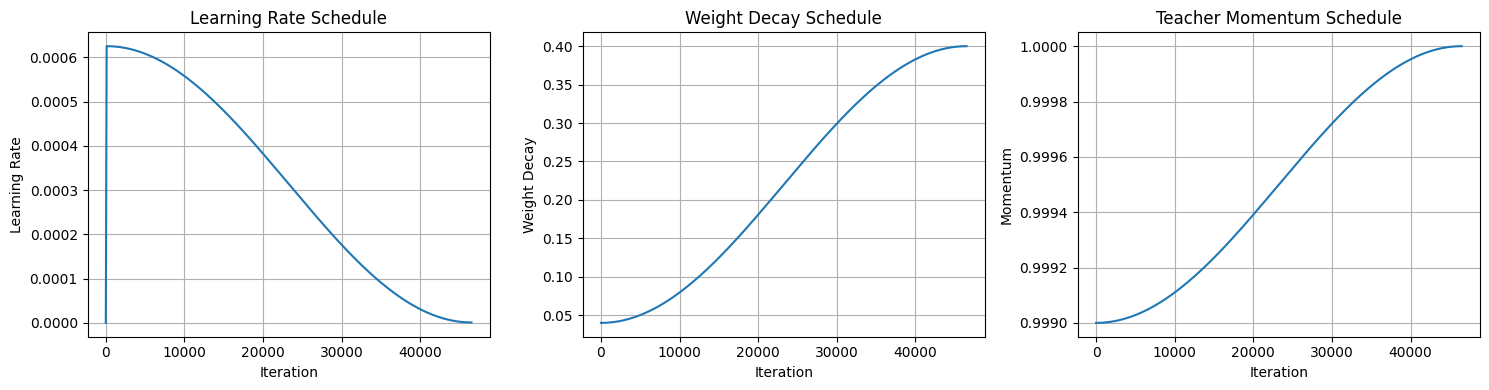

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot learning rate schedule
iterations = np.arange(len(lr_schedule))
ax1.plot(iterations, lr_schedule)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Learning Rate')
ax1.set_title('Learning Rate Schedule')
ax1.grid(True)

# Plot weight decay schedule
ax2.plot(iterations, wd_schedule)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Weight Decay')
ax2.set_title('Weight Decay Schedule')
ax2.grid(True)

# Plot momentum schedule
ax3.plot(iterations, momentum_schedule)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Momentum')
ax3.set_title('Teacher Momentum Schedule')
ax3.grid(True)

plt.tight_layout()
plt.show()



## Training

In [10]:
start_epoch = 0

# Training loop
print(f"Starting DINO training for {config.EPOCHS} epochs!")
start_time = time.time()

for epoch in trange(start_epoch, config.EPOCHS):
    # Train one epoch
    train_stats = train_one_epoch(
        student, teacher, dino_loss, data_loader, optimizer,
        lr_schedule, wd_schedule, momentum_schedule, epoch,
        fp16_scaler, config, device
    )

    # Save checkpoint
    save_dict = {
        'student': student.state_dict(),
        'teacher': teacher.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch + 1,
        'config': config,
        'dino_loss': dino_loss.state_dict(),
    }
    if fp16_scaler is not None:
        save_dict['fp16_scaler'] = fp16_scaler.state_dict()

    torch.save(save_dict, os.path.join(config.OUTPUT_DIR, 'checkpoint.pth'))

    # Save checkpoint at specific frequencies
    if config.SAVECKP_FREQ and (epoch + 1) % config.SAVECKP_FREQ == 0:
        torch.save(save_dict, os.path.join(config.OUTPUT_DIR, f'checkpoint{epoch:04}.pth'))

    # Update metrics
    metrics_tracker.update(
        train_stats['loss'],
        train_stats['lr'],
        train_stats['wd'],
        epoch
    )

    # Log stats
    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()}, 'epoch': epoch}
    with open(os.path.join(config.OUTPUT_DIR, "log.txt"), "a") as f:
        f.write(json.dumps(log_stats) + "\n")

    print(f"Epoch {epoch}/{config.EPOCHS} - Loss: {train_stats['loss']:.4f}")

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training completed in {total_time_str}')


Starting DINO training for 500 epochs!


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: [0/500]  [ 0/93]  eta: 0:01:32  loss: 5.453519 (5.453519)  lr: 0.000000 (0.000000)  wd: 0.040000 (0.040000)  time: 0.996513  data: 0.361628  max mem: 7464
Epoch: [0/500]  [10/93]  eta: 0:00:39  loss: 5.645229 (5.646256)  lr: 0.000034 (0.000034)  wd: 0.040000 (0.040000)  time: 0.474937  data: 0.271930  max mem: 7691
Epoch: [0/500]  [20/93]  eta: 0:00:32  loss: 5.850085 (5.786984)  lr: 0.000068 (0.000068)  wd: 0.040000 (0.040000)  time: 0.413521  data: 0.258568  max mem: 7691
Epoch: [0/500]  [30/93]  eta: 0:00:26  loss: 5.959777 (5.842603)  lr: 0.000136 (0.000102)  wd: 0.040000 (0.040000)  time: 0.402934  data: 0.251960  max mem: 7691
Epoch: [0/500]  [40/93]  eta: 0:00:22  loss: 5.949001 (5.865876)  lr: 0.000204 (0.000136)  wd: 0.040000 (0.040000)  time: 0.405404  data: 0.254211  max mem: 7691
Epoch: [0/500]  [50/93]  eta: 0:00:18  loss: 5.932414 (5.877876)  lr: 0.000272 (0.000170)  wd: 0.040001 (0.040000)  time: 0.422069  data: 0.268838  max mem: 7691
Epoch: [0/500]  [60/93]  eta

## Metrics

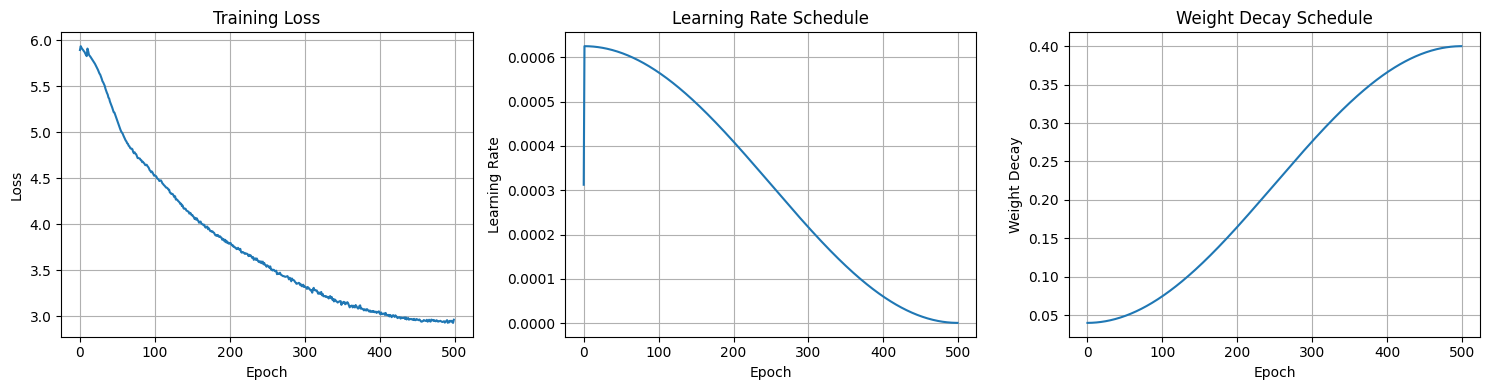

In [11]:
metrics_tracker.plot()
metrics_tracker.save(os.path.join(config.OUTPUT_DIR, 'training_metrics.json'))

## Extract and Save Final Model

In [12]:
final_model = student.backbone

# Test the model with a dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = final_model(dummy_input)
    if isinstance(output, dict):
        print(f"Model output shape: {output['last_hidden_state'].shape}")
    else:
        print(f"Model output shape: {output.shape}")

Model output shape: torch.Size([1, 197, 384])


In [13]:
def save_model_to_hub(model, config, metrics_tracker):
    """Save the trained model to HuggingFace Hub"""

    # Prepare model card
    model_card_content = f"""
# DINO ViT-Small Custom Dataset

This model is a Vision Transformer (ViT) Small model trained using DINO (self-DIstillation with NO labels) on a custom dataset.

## Model Details

- **Architecture**: ViT-Small (patch size 16)
- **Pre-training Method**: DINO
- **Training Epochs**: {config.EPOCHS}
- **Output Dimension**: {config.OUT_DIM}
- **Dataset Size**: ~3000 images
- **Base Model**: WinKawaks/vit-small-patch16-224

## Training Configuration

- Batch Size: {config.BATCH_SIZE_PER_GPU}
- Learning Rate: {config.LR}
- Teacher Temperature: {config.TEACHER_TEMP}
- Local Crops: {config.LOCAL_CROPS_NUMBER}
- Weight Decay: {config.WEIGHT_DECAY} → {config.WEIGHT_DECAY_END}
- Optimizer: {config.OPTIMIZER}

## Training Results

- Final Loss: {metrics_tracker.losses[-1]:.4f}
- Training Time: {total_time_str}

## Usage

```python
from transformers import ViTModel
import torch

# Load the model
model = ViTModel.from_pretrained("{config.HF_REPO_NAME}")

# Use for feature extraction
model.eval()
with torch.no_grad():
    features = model(images).last_hidden_state
Training Curves
See the training plots in the repository for loss, learning rate, and weight decay curves.
"""

    model_save_path = os.path.join(config.OUTPUT_DIR, "final_model")
    model.save_pretrained(model_save_path)

    # Save model card
    with open(os.path.join(model_save_path, "README.md"), "w") as f:
        f.write(model_card_content)

    # Save training plots
    metrics_tracker.plot()
    plt.savefig(os.path.join(model_save_path, "training_curves.png"), dpi=150, bbox_inches='tight')

    # Save training config
    config_dict = {k: v for k, v in vars(config).items() if not k.startswith('_')}
    with open(os.path.join(model_save_path, "training_config.json"), "w") as f:
        json.dump(config_dict, f, indent=2)

    print(f"Model saved locally at: {model_save_path}")

    # Upload to HuggingFace Hub
    if config.HF_TOKEN:
        try:
            # Create repo if it doesn't exist
            api = HfApi()
            repo_url = create_repo(
                repo_id=config.HF_REPO_NAME,
                token=config.HF_TOKEN,
                exist_ok=True,
                private=False
            )
            print(f"Repository created/found at: {repo_url}")

            # Upload the model folder
            upload_folder(
                folder_path=model_save_path,
                repo_id=config.HF_REPO_NAME,
                token=config.HF_TOKEN,
                commit_message="Upload DINO pre-trained ViT-Small model"
            )
            print(f"Model successfully uploaded to: https://huggingface.co/{config.HF_REPO_NAME}")
        except Exception as e:
            print(f"Error uploading to HuggingFace Hub: {e}")
            print("Please ensure you have logged in with 'huggingface-cli login' or set config.HF_TOKEN")
    else:
        print("No HuggingFace token provided. Model saved locally only.")
        print("To upload to HuggingFace Hub, either:")
        print("1. Run 'huggingface-cli login' in terminal, or")
        print("2. Set config.HF_TOKEN with your access token")

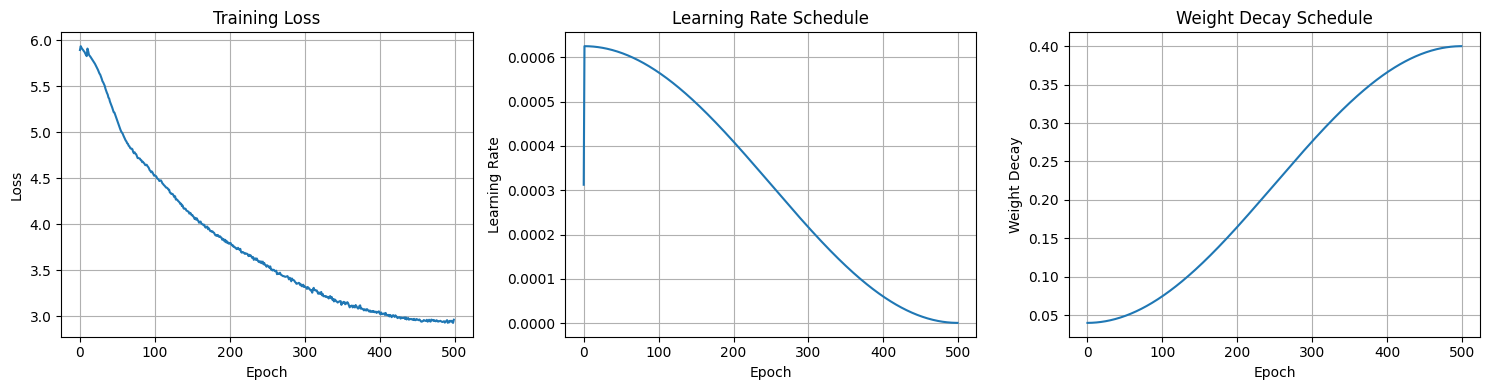

Model saved locally at: ./dino_hf_checkpoints\final_model
Repository created/found at: https://huggingface.co/odinson/dino-vit-small-custom


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model successfully uploaded to: https://huggingface.co/odinson/dino-vit-small-custom


<Figure size 640x480 with 0 Axes>

In [14]:
save_model_to_hub(final_model, config, metrics_tracker)

## Test the Saved Model

In [15]:
test_model = ViTModel.from_pretrained(os.path.join(config.OUTPUT_DIR, "final_model"))
test_model.eval()
test_model.to(device)

with torch.no_grad():
    test_input = torch.randn(1, 3, 224, 224).to(device)
    test_output = test_model(test_input)
    print(f"Test output shape: {test_output.last_hidden_state.shape}")
    print("Model successfully loaded and tested!")

Test output shape: torch.Size([1, 197, 384])
Model successfully loaded and tested!
